<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ AQI time series analysis and forecasting ⚡</span>

### **Step1: Importing the libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

### **Step2: Loading the data**

In [ ]:
# Loading the dataset
df = pd.read_csv("../2. JSON to CSV/updated_aqi_dataset_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

### **Step3: Analysing the data**

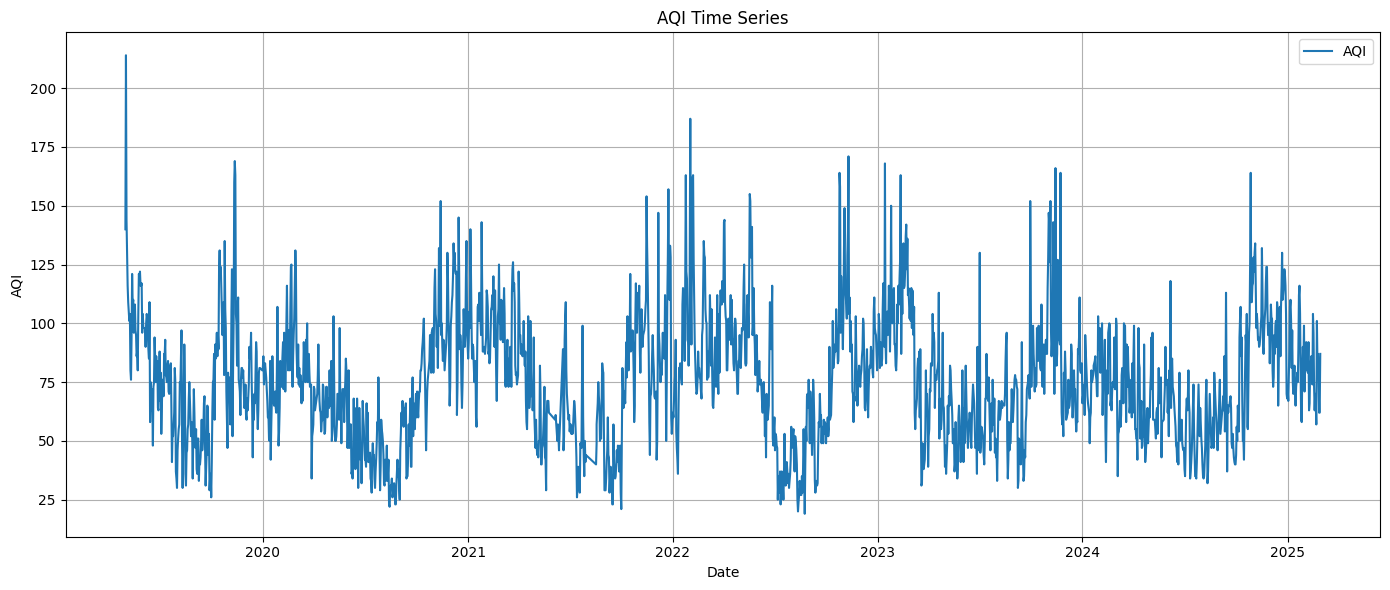

In [3]:
# Plot AQI over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI'], label='AQI')
plt.title('AQI Time Series')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

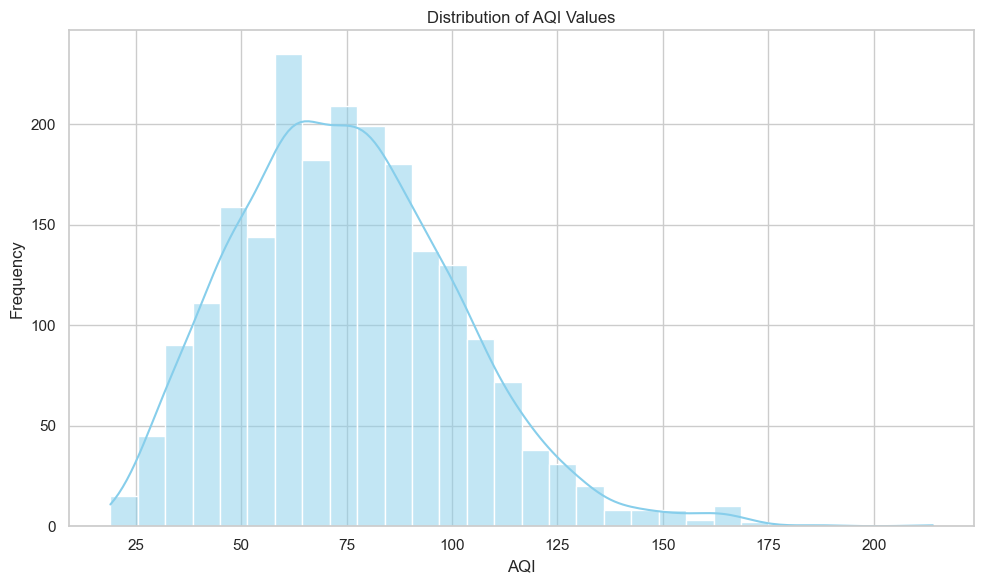

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['AQI'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of AQI Values')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## **Step4: Distributional view of data**

Normal Distribution: mu=75.12435476302205, std=26.41754076124926


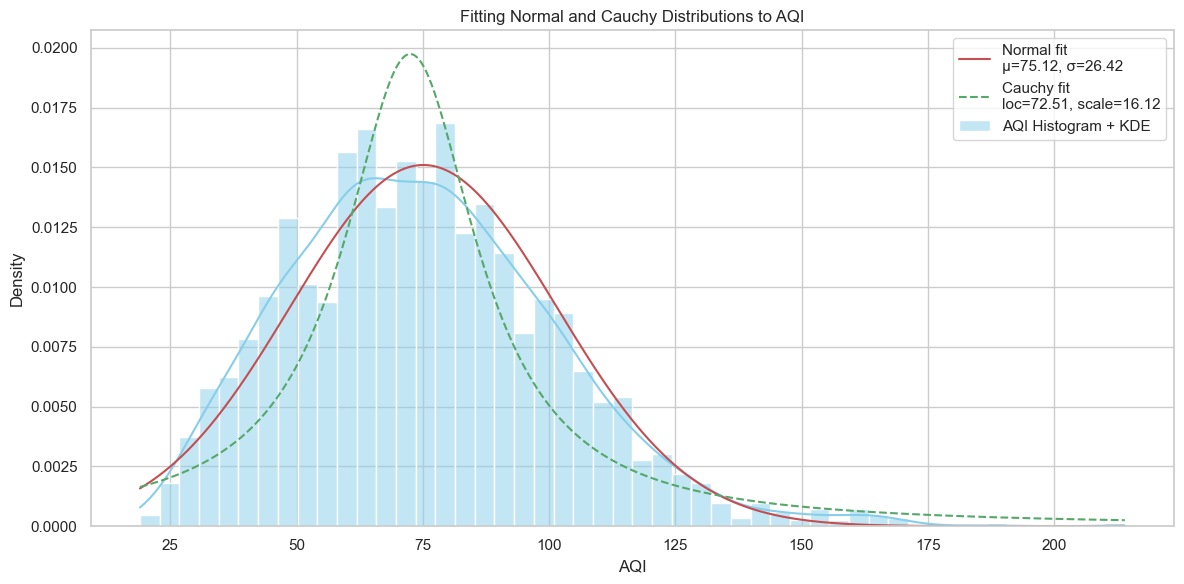

In [ ]:
from scipy.stats import norm, cauchy

aqi = df['AQI']

# Fitting normal and cauchy distributions
mu_norm, std_norm = norm.fit(aqi)
loc_cauchy, scale_cauchy = cauchy.fit(aqi)

print(f"Normal Distribution: mu={mu_norm}, std={std_norm}")

# Generating x values for PDFs
x = np.linspace(aqi.min(), aqi.max(), 1000)
pdf_norm = norm.pdf(x, mu_norm, std_norm)
pdf_cauchy = cauchy.pdf(x, loc_cauchy, scale_cauchy)

# Plot histogram + KDE
plt.figure(figsize=(12, 6))

# Histogram with KDE
sns.histplot(aqi, bins=50, kde=True, stat="density", color='skyblue', alpha=0.5, label="AQI Histogram + KDE")

# Overlay PDFs
plt.plot(x, pdf_norm, 'r-', label=f'Normal fit\nμ={mu_norm:.2f}, σ={std_norm:.2f}')
plt.plot(x, pdf_cauchy, 'g--', label=f'Cauchy fit\nloc={loc_cauchy:.2f}, scale={scale_cauchy:.2f}')

# Styling
plt.title('Fitting Normal and Cauchy Distributions to AQI')
plt.xlabel('AQI')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Step5: Decompostion of the data(Trend, seasonality, residuals)**

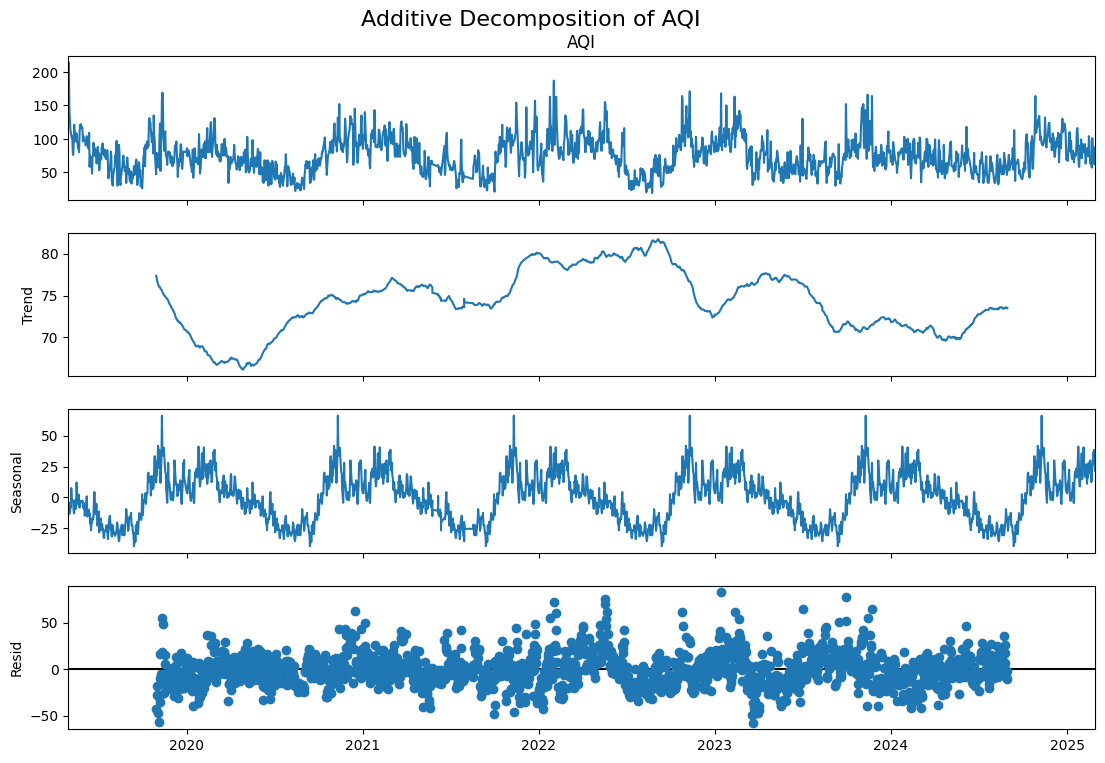

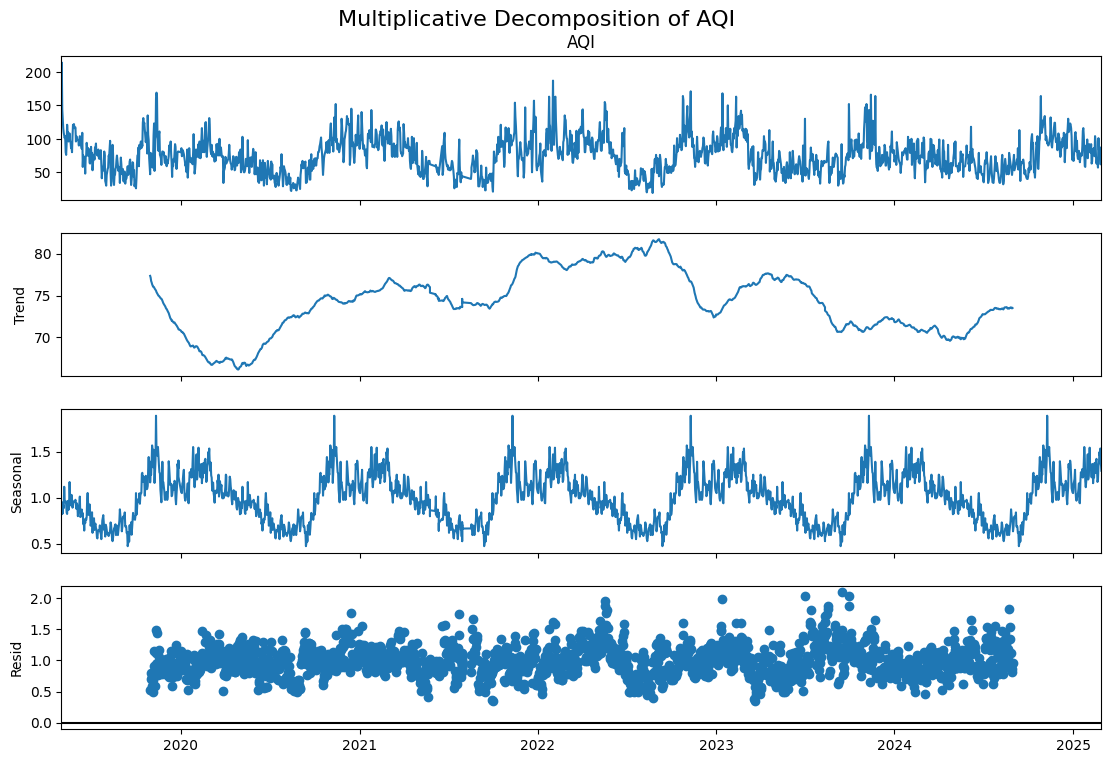

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- ADDITIVE DECOMPOSITION ---
result_add = seasonal_decompose(df['AQI'], model='additive', period=365)
fig = result_add.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Additive Decomposition of AQI', fontsize=16)
plt.show()

# --- MULTIPLICATIVE DECOMPOSITION ---
result_mult = seasonal_decompose(df['AQI'], model='multiplicative', period=365)
fig = result_mult.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Multiplicative Decomposition of AQI', fontsize=16)
plt.show()

## **Step6: Stationarity checking**

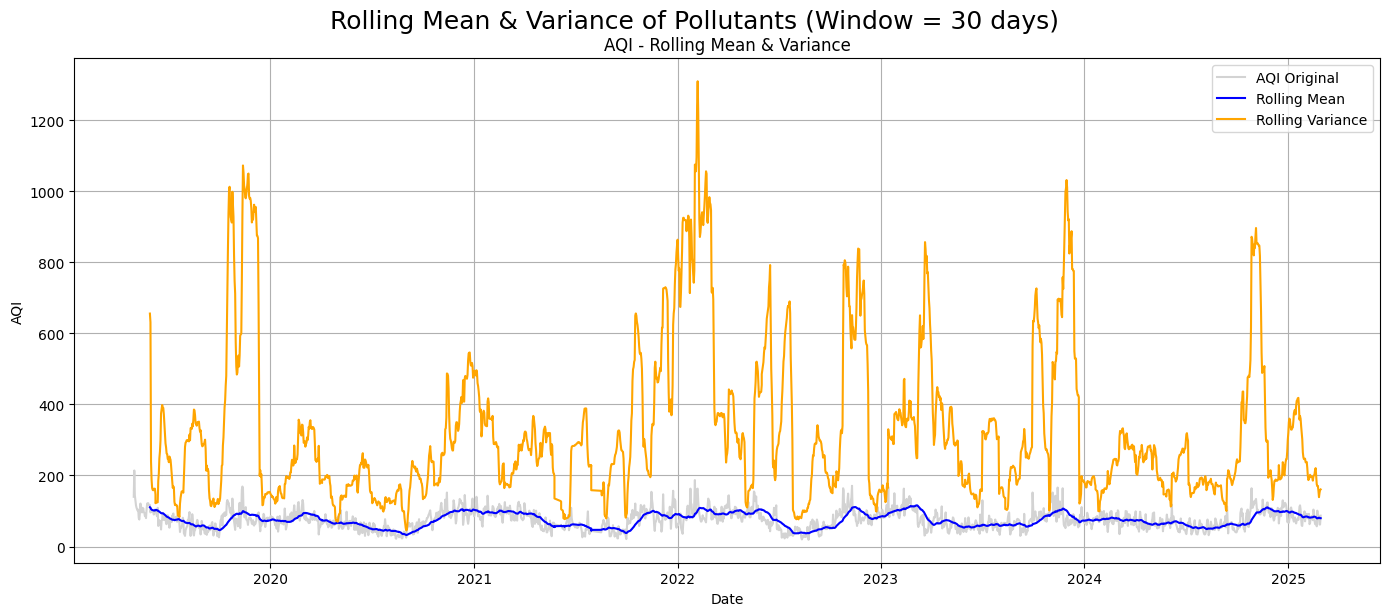

In [ ]:
# Plotting mean and variance of AQI
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI'], label=f'{'AQI'} Original', color='lightgray')
plt.plot(df['AQI'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


## **Step7: Data transformation**

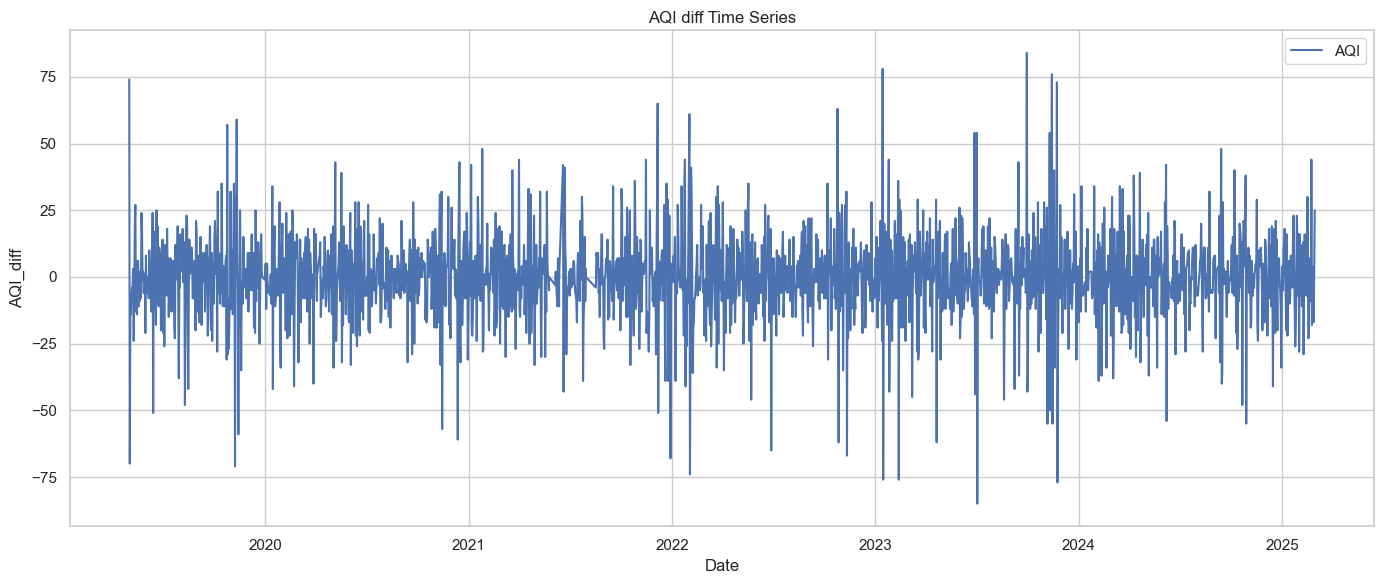

In [ ]:
df['AQI_diff'] = df['AQI'].diff()

# Plot AQI difference over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_diff'], label='AQI')
plt.title('AQI diff Time Series')
plt.xlabel('Date')
plt.ylabel('AQI_diff')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

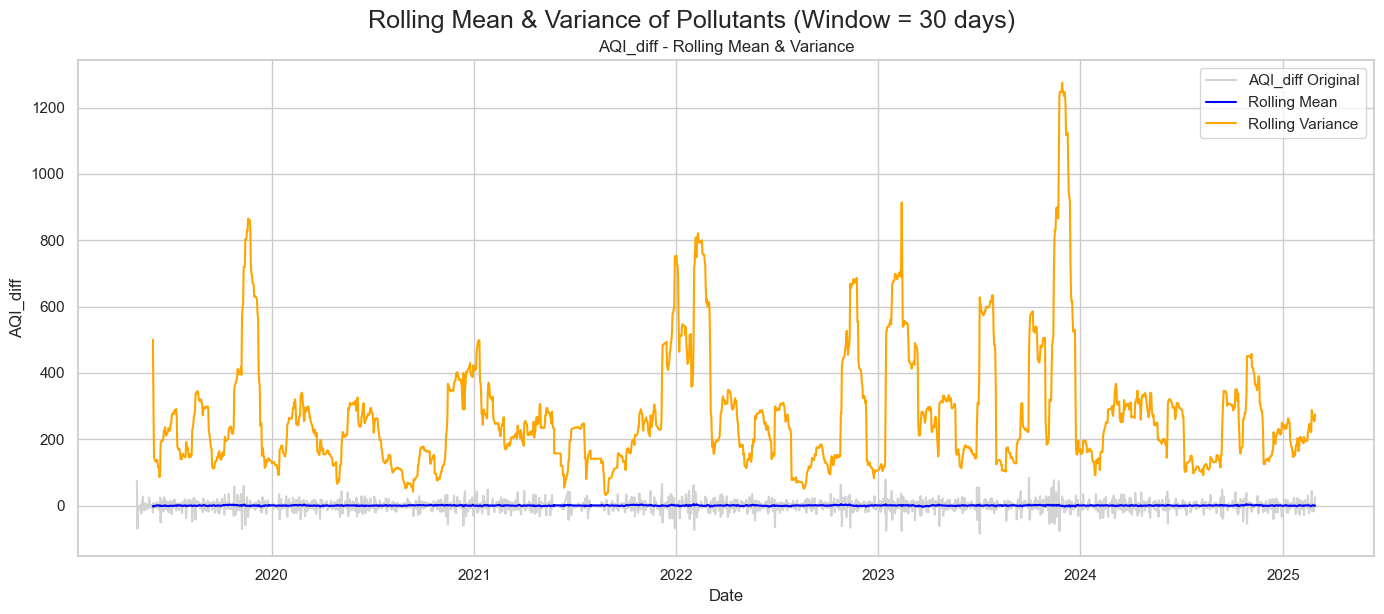

In [ ]:
# Plotting mean and variance of AQI difference
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_diff'], label=f'{'AQI_diff'} Original', color='lightgray')
plt.plot(df['AQI_diff'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_diff'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_diff'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI_diff')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI (Window = 30 days)', fontsize=18, y=1.02)
plt.show()

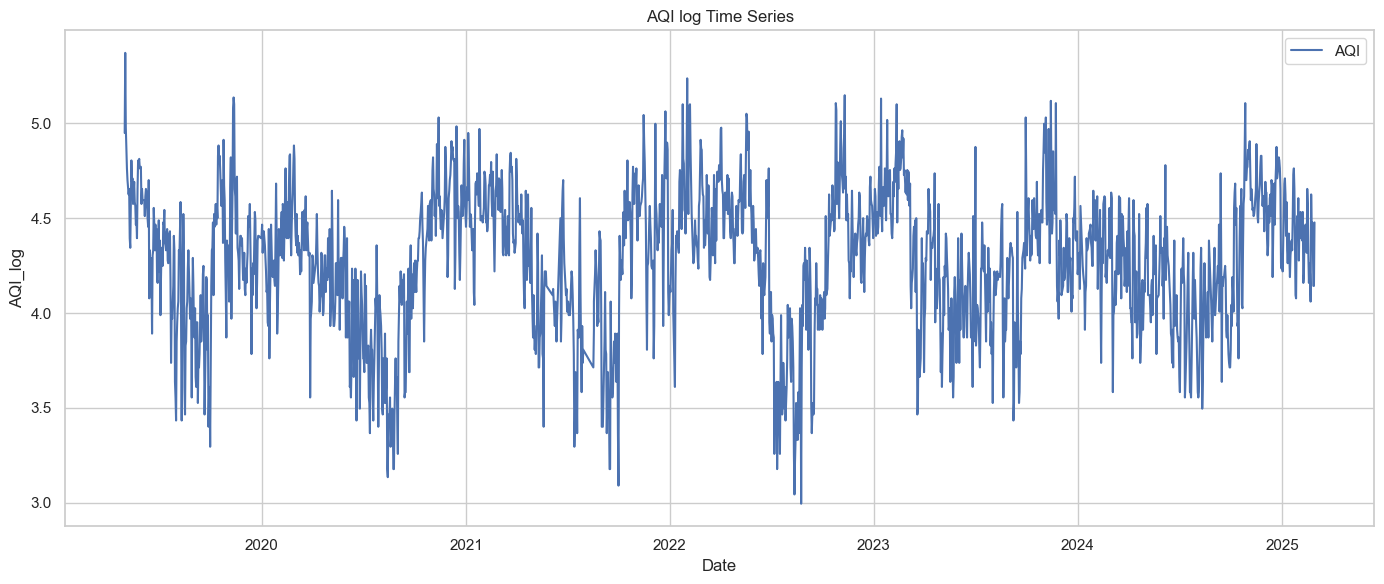

In [113]:
df['AQI_log'] = np.log(df['AQI'] + 1)  # Adding 1 to avoid log(0)

# Plot AQI log over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label='AQI')
plt.title('AQI log Time Series')
plt.xlabel('Date')
plt.ylabel('AQI_log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

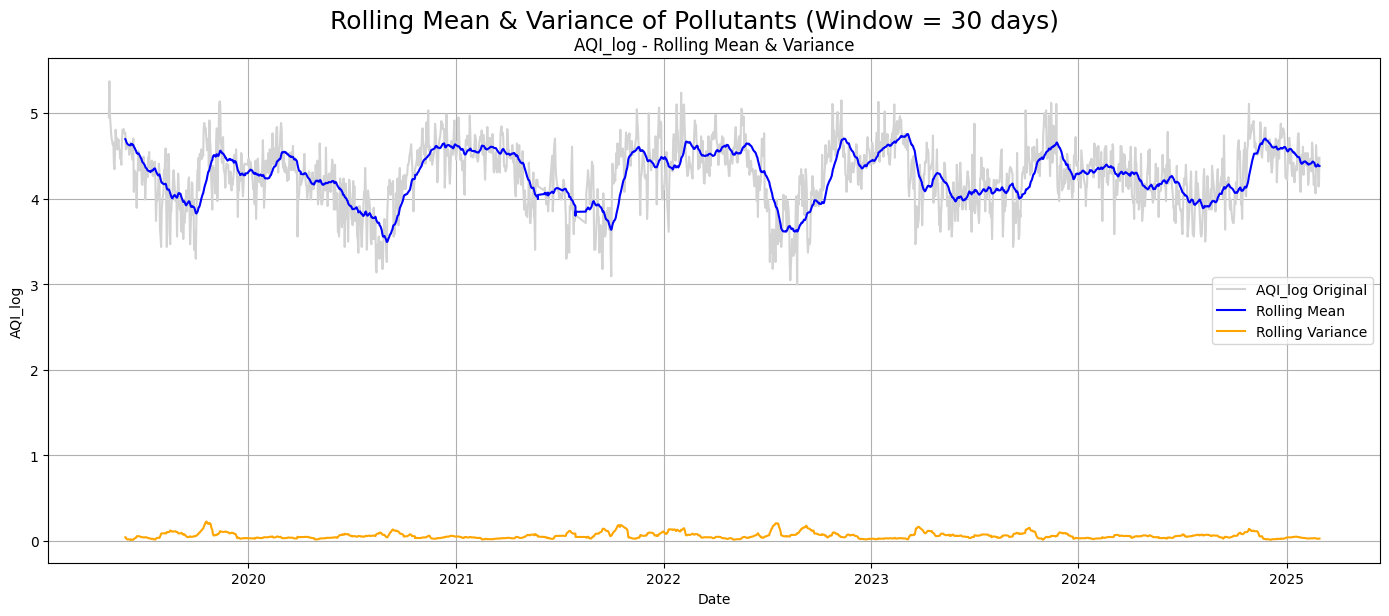

In [ ]:
# Plotting mean and variance of AQI log
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label=f'{'AQI_log'} Original', color='lightgray')
plt.plot(df['AQI_log'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_log'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_log'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI_log')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


## **Step8: Differencing Method used to make stationary data**

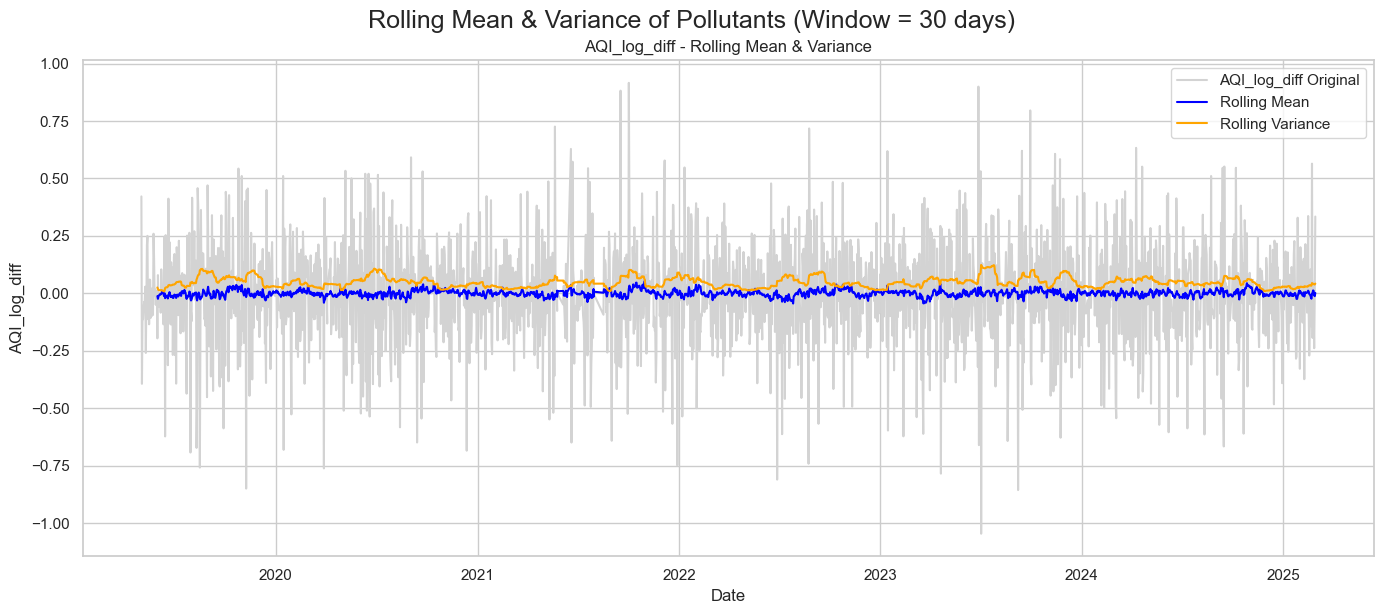

In [ ]:
df['AQI_log_diff'] = df['AQI_log'].diff()
# Plotting mean and variance of AQI log difference
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log_diff'], label=f'{'AQI_log_diff'} Original', color='lightgray')
plt.plot(df['AQI_log_diff'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_log_diff'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_log_diff'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI_log_diff')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


## **Step9: Plotting ACF to verify stationarity**

<Figure size 1200x600 with 0 Axes>

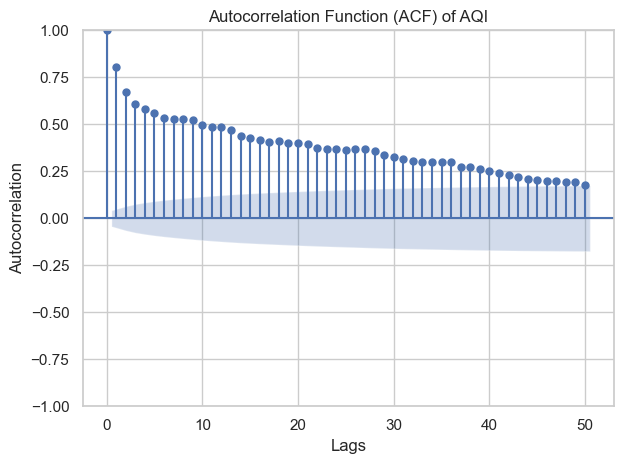

In [81]:
# ACF Plot of original AQI
plt.figure(figsize=(12, 6))
plot_acf(aqi, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

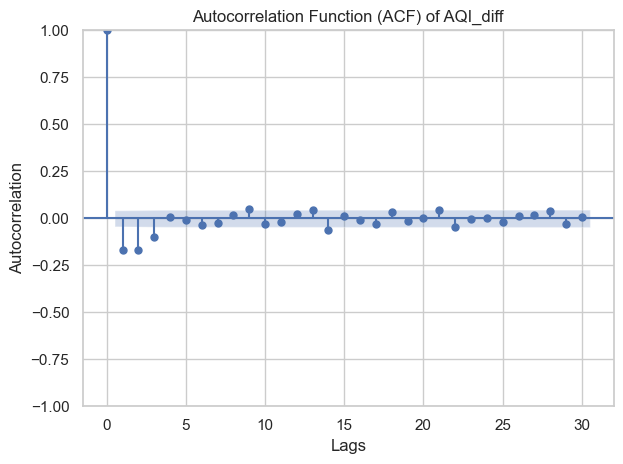

In [87]:
# Drop NaN introduced by differencing
aqi_diff = df['AQI_diff'].dropna()

# ACF Plot of AQI_diff
plt.figure(figsize=(12, 6))
plot_acf(aqi_diff, lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_diff')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

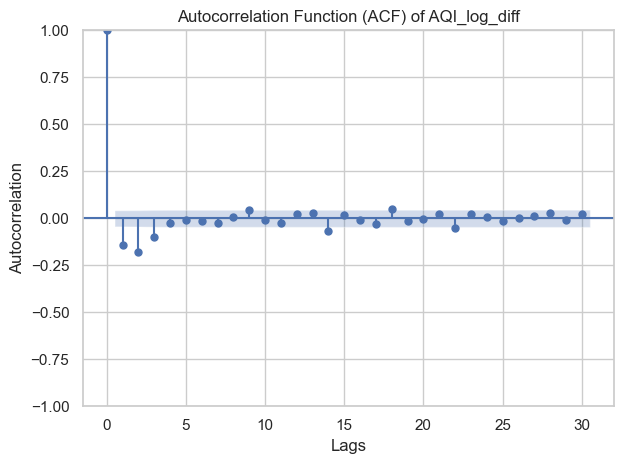

In [ ]:
# Drop NaN introduced by differencing
aqi_log_diff = df['AQI_log_diff'].dropna()

# ACF Plot of AQI_log_diff
plt.figure(figsize=(12, 6))
plot_acf(aqi_log_diff, lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_log_diff')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Step10: Model Selection and Fitting**

In [ ]:
# Fit ARIMA models
from statsmodels.tsa.arima.model import ARIMA

aqi_log = df['AQI_log']

# Fit MA(2)
model_ma2 = ARIMA(aqi_log, order=(0, 1, 2))  # (p=0, d=1, q=2)
result_ma2 = model_ma2.fit()


# Fit MA(3)
model_ma3 = ARIMA(aqi_log, order=(0, 1, 3))  # (p=0, d=1, q=3)
result_ma3 = model_ma3.fit()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

## **Step11: Checking AIC score**

In [66]:
print("MA(2) AIC:", result_ma2.aic)
print("MA(3) AIC:", result_ma3.aic)

MA(2) AIC: -766.1279150729997
MA(3) AIC: -813.5223440844743


## **Step12: Verifying residuals characteristics**

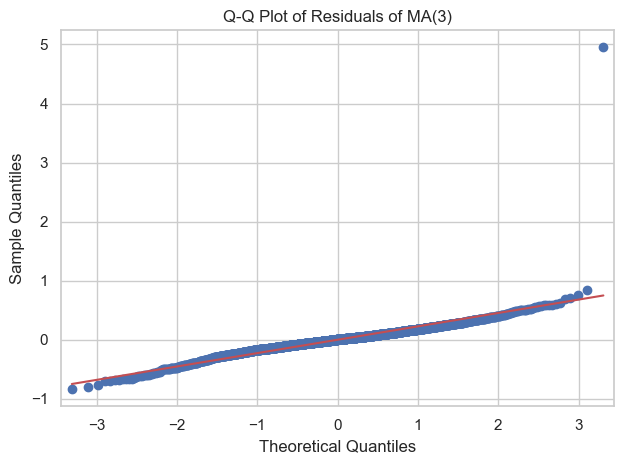

In [91]:
import statsmodels.api as sm

# Plotting residuals of MA(3)
residuals = result_ma3.resid

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals of MA(3)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.tight_layout()
plt.show()

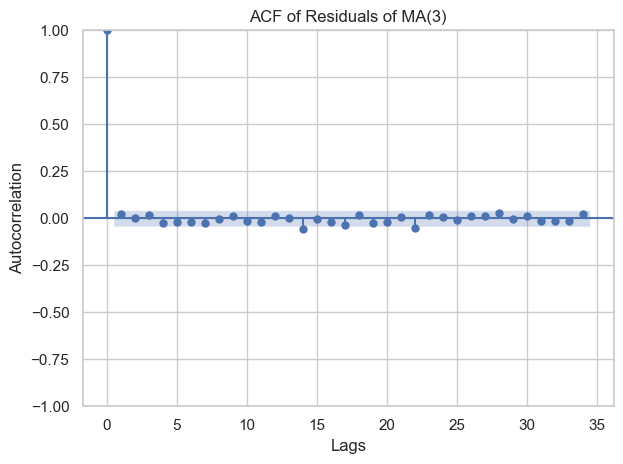

In [88]:
# ACF of residuals of MA(3)
residuals = result_ma3.resid
plot_acf(residuals)
plt.title("ACF of Residuals of MA(3)")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

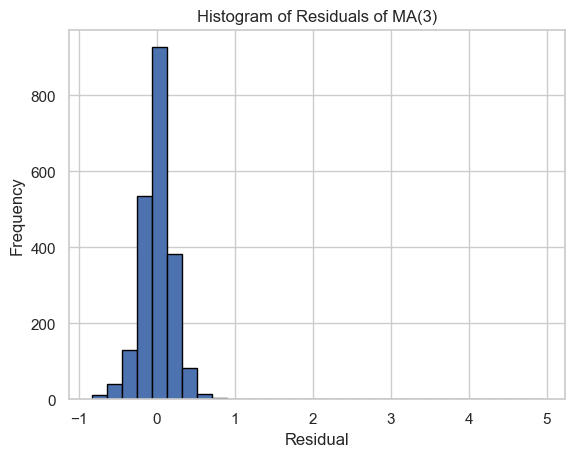

In [90]:
# Histogram of residuals of MA(3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals of MA(3)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

## **Step13: AQI Forecast (3 Days Ahead)**

In [ ]:
# Step 1: Forecast the next 3 steps (log scale)
forecast_log = result_ma3.forecast(steps=3)

# Step 2: Convert back to original AQI scale
forecast_original_scale = np.exp(forecast_log) - 1
forecast_original_scale = forecast_original_scale.clip(lower=0)

# Step 3: Create a DataFrame with proper datetime index
# Our last date in original AQI data is:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3)
forecast_df = pd.DataFrame(forecast_original_scale.values, index=future_dates, columns=['Forecasted AQI'])

# Step 4: Convert to integer
forecast_df['Forecasted AQI'] = np.floor(forecast_df['Forecasted AQI']).astype(int)

# Step 5: Insert Actual AQI values of next 3 days
actual_values = [85, 77, 65]  # Replacing with actual values 
forecast_df['Actual AQI'] = actual_values

# Step 6: View the result
forecast_df.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted AQI,Actual AQI
2025-03-01 00:00:00+00:00,85,85
2025-03-02 00:00:00+00:00,80,77
2025-03-03 00:00:00+00:00,77,65
